<img align="right" width="250" height="150" src="https://lh3.googleusercontent.com/p/AF1QipPWZQfa087JiVjutpUTVEGRnh6W214Wjm439gKQ=w1080-h608-p-no-v0">

## **Proyecto:** Retención de usuarios de la Plataforma Digital

#### El objetivo de este notebook es hacer un análisis de Cohort de los usuarios de plataforma visualizando la adquisición vs. la retención de los mismos.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import seaborn as sns 
import matplotlib.pyplot as plt
#from matplotlib.ticker import FuncFormatter
%matplotlib inline

try:
    # Monto la unidad de drive porque los archivos son muy grandes
    from google.colab import drive
    drive.mount('/content/drive')
    DIR = '/content/drive/MyDrive/Trayecto3-DataDriven/Data/'
except:
    # Sino lo consigo asumo que estoy trabajando local
    DIR = os.path.abspath(r'..\Data\Export') + '\\'

FECHA_INICIO = dt.datetime(2019, 11, 1)
FECHA_CORTE = dt.datetime(2022, 4, 30)

In [2]:
file = DIR + 'Usuarios.parquet'
df = pd.read_parquet(file, columns=['ID_USER', 'FechaCreacion', 'LAST_LOGIN'])

In [3]:
# Filtro a partir de cuando quiero hacer el cohorte
df = df[df['FechaCreacion'] >= FECHA_INICIO]

In [4]:
# Creamos la columna cohort_group con el YYYY-MM de onboarding del usuario
df['COHORT_GROUP'] = df['FechaCreacion'].apply(lambda x: x.strftime('%Y-%m'))
# Evaluamos si abandono o no la plataforma si hace 90 dias que no accede
df['ABANDONO_PD'] = ((dt.datetime.now() - df['LAST_LOGIN']).astype('timedelta64[D]') > 90).astype(int)

In [5]:
#df[((df['LAST_LOGIN']>dt.datetime(2022, 3, 30)) & (df['LAST_LOGIN']<dt.datetime(2022, 5, 1)) & (df['ABANDONO_PD']==1))].sample(20)

In [6]:
# Filtro hasta los creados en la fecha de corte
df = df[df['FechaCreacion'] <= FECHA_CORTE]
# Topeamos la fecha de último login a la fecha de corte
df.loc[df['LAST_LOGIN'] > FECHA_CORTE, 'LAST_LOGIN'] = FECHA_CORTE
# Creamos la columna periodo con el YYYY-MM de la fecha de último logín
df['PER_LLOGIN'] = df['LAST_LOGIN'].apply(lambda x: x.strftime('%Y-%m'))

In [7]:
df_cg = df.groupby(['COHORT_GROUP']).aggregate({'ABANDONO_PD': 'count'})

In [8]:
df_ab = df.groupby(['COHORT_GROUP', 'PER_LLOGIN']).aggregate({'ABANDONO_PD': 'sum'}).groupby('COHORT_GROUP').cumsum()

In [9]:
# Tenemos la matriz con los abandonos y la serie con los totales del cohorte
# Restamos el total del vector de cohortes menos la matriz de abandonos y nos da la matriz de Retención
df_ch = (df_cg - df_ab)

In [10]:
# Ahora la expresamos en %
retencionp = df_ch['ABANDONO_PD'].unstack(1).divide(df_cg.squeeze(), axis=0)

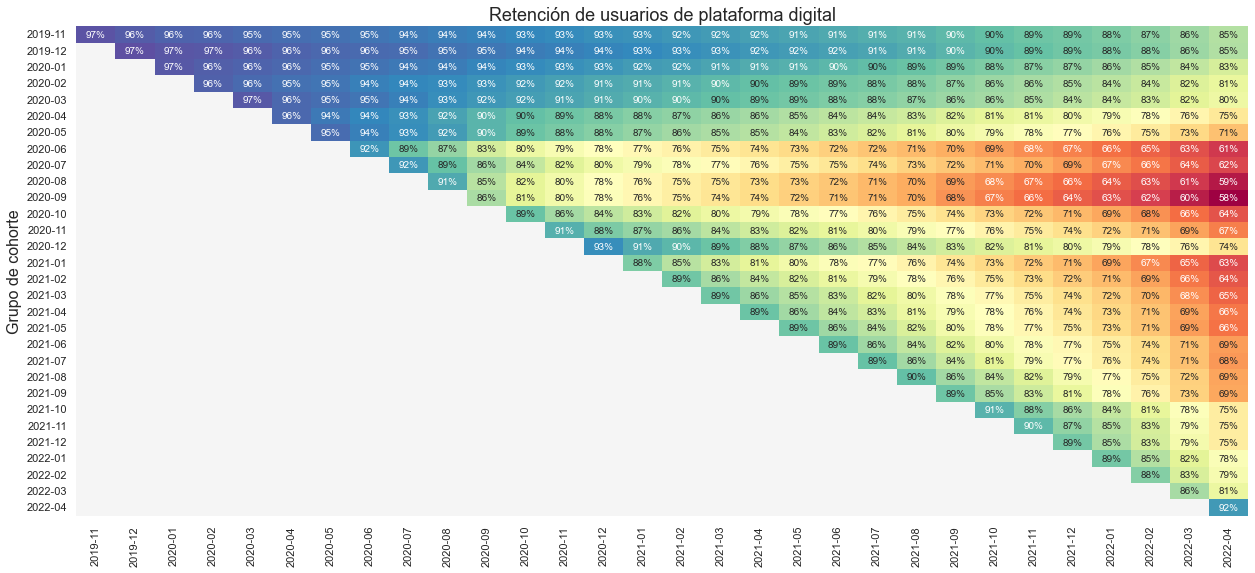

In [22]:
#Le damos las siguientes especificaciones a nuetros grafico.
plt.figure(figsize = (21, 9))
plt.title('Retención de usuarios de plataforma digital', fontsize = 18)
# Por si quiero formatear en % la escala de colores en caso de que la muestra
#fmt = lambda x,pos: '{:.0}'.format(x)
sns.set(font_scale=1)
ax = sns.heatmap(data=retencionp,
            annot=True,
            fmt='.0%',
            #square=False,
            annot_kws={'size': 10},
            #linewidths=.005,
            cbar=False,
            #cbar_kws={'label': 'Tasa de Retención %', 'format': FuncFormatter(fmt), 'pad': 0.005},
            cmap = 'Spectral')

# Por si quiero plotear las lineas divisorias
#ax.hlines([0] + list(retencionp.reset_index().index + 1), *ax.get_xlim())
#ax.vlines([0] + list(retencionp.reset_index().index + 1), *ax.get_xlim())

#b, t = plt.ylim() # descubra los valores de bottom y top del heatmap
#b += 0.5 # Agregue 0.5 a la parte inferior
#t -= 0.5 # Resta 0.5 de la parte superior
#plt.ylim(b, t)
#ax.set_yticklabels(list(ytl), size = 12)
#ax.set_xticklabels(list(xtl), size = 12)
plt.ylabel('Grupo de cohorte', fontsize = 16)
plt.xlabel('')
ax.set_facecolor('whitesmoke')
plt.show()